In [1]:
import os
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D, ZeroPadding2D, Conv2DTranspose
from keras.models import Model
from keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam
import keras

2023-08-06 08:53:45.266587: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-06 08:53:48.081395: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/aaslan/venv-jupyter-310/lib/python3.8/site-packages/cv2/../../lib64:
2023-08-06 08:53:48.081560: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/aaslan/venv-jupyter-310/lib/python3.8/site-packag

In [2]:
SIZE = 256
image_s =[]
dataset_s=[]
image_labels = []
image_directory_2  = 'good/'
good_images_2 = os.listdir(image_directory_2)
for i, image_name in enumerate(good_images_2):
    if (image_name.endswith('png')):
        image_s = cv2.imread(image_directory_2 + image_name)
        image_s = Image.fromarray(image_s,'RGB')
        image_s = image_s.resize((SIZE, SIZE)) 
        dataset_s.append(np.array(image_s))
dataset_s = np.array(dataset_s)
train_x = dataset_s[0:450]
train_x = train_x.astype('float32') / 255.
val_x = dataset_s[450:500]
val_x = val_x.astype('float32') / 255.

In [3]:
img_rows, img_cols, channels = 256, 256, 3
input_shape = (img_rows, img_cols, channels)

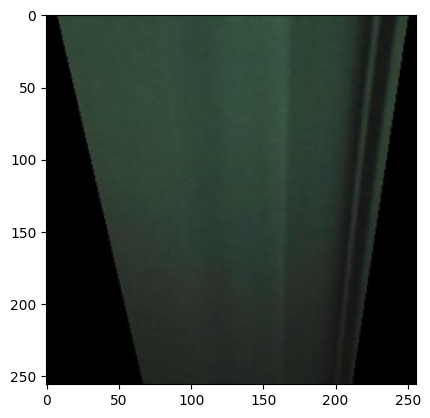

In [5]:
plt.imshow(train_x[1])

In [11]:
def build_encoder(latent):
    model = keras.Sequential()
    model.add(Conv2D(16, kernel_size=3, strides=2, input_shape=input_shape, padding="same", activation='relu'))
    model.add(Conv2D(32, kernel_size=3, strides=2, padding="same", activation='relu'))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same", activation='relu'))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same", activation='relu'))
    model.add(Flatten())
    model.add(Dense(latent, activation='relu'))
    model.summary()
    return model

def build_decoder(latent):
    model = keras.Sequential()
    model.add(Dense(16 * 16 * 128, activation='relu', input_shape=(latent,)))
    model.add(Reshape((16, 16, 128)))
    model.add(Conv2DTranspose(64, kernel_size=3, strides=2, padding="same", activation='relu'))
    model.add(Conv2DTranspose(32, kernel_size=3, strides=2, padding="same", activation='relu'))
    model.add(Conv2DTranspose(16, kernel_size=3, strides=2, padding="same", activation='relu'))
    model.add(Conv2DTranspose(3, kernel_size=3, strides=2, padding="same", activation='relu'))
    model.summary()
    encoded_repr = Input(shape=(latent,))
    img = model(encoded_repr)
    return keras.Model(encoded_repr, img)


In [8]:
latent_size = 128
encoder = build_encoder(latent_size)
decoder = build_decoder(latent_size)
autoencoder = keras.Model(encoder.inputs, decoder(encoder.outputs))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 128)               4194432   
                                                                 
Total params: 4,291,872
Trainable params: 4,291,872
Non-

In [5]:
latent_size = 128
encoder = build_encoder(latent_size)
decoder = build_decoder(latent_size)
autoencoder = keras.Model(encoder.inputs, decoder(encoder.outputs))
autoencoder.compile(optimizer='adam', loss='mse',metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 128)               4194432   
                                                                 
Total params: 4,291,872
Trainable params: 4,291,872
Non-

In [7]:
import time
start_time = time.time()
autoencoder.fit(train_x, train_x, epochs=200, batch_size=32, validation_data=(val_x, val_x))
end_time = time.time()
training_time = end_time - start_time

print("Training time: {:.2f} seconds".format(training_time))

Epoch 1/200


2023-07-31 16:20:28.307824: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-07-31 16:20:28.309011: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.0
2023-07-31 16:20:28.309022: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:237] Used ptxas at ptxas
2023-07-31 16:20:28.309070: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:318] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-07-31 16:20:30.485585: W tenso

15/15 [==============================] - 9s 46ms/step - loss: 0.0297 - accuracy: 0.3926 - val_loss: 0.0266 - val_accuracy: 0.3934
Epoch 2/200
15/15 [==============================] - 0s 18ms/step - loss: 0.0214 - accuracy: 0.3914 - val_loss: 0.0148 - val_accuracy: 0.3851
Epoch 3/200
15/15 [==============================] - 0s 19ms/step - loss: 0.0094 - accuracy: 0.4546 - val_loss: 0.0057 - val_accuracy: 0.5470
Epoch 4/200
15/15 [==============================] - 0s 19ms/step - loss: 0.0049 - accuracy: 0.6315 - val_loss: 0.0040 - val_accuracy: 0.7413
Epoch 5/200
15/15 [==============================] - 0s 18ms/step - loss: 0.0036 - accuracy: 0.7976 - val_loss: 0.0033 - val_accuracy: 0.8315
Epoch 6/200
15/15 [==============================] - 0s 18ms/step - loss: 0.0032 - accuracy: 0.8391 - val_loss: 0.0031 - val_accuracy: 0.8422
Epoch 7/200
15/15 [==============================] - 0s 19ms/step - loss: 0.0030 - accuracy: 0.8434 - val_loss: 0.0029 - val_accuracy: 0.8499
Epoch 8/200
15/15 

15/15 [==============================] - 0s 19ms/step - loss: 6.3613e-05 - accuracy: 0.9649 - val_loss: 6.6338e-05 - val_accuracy: 0.9649
Epoch 111/200
15/15 [==============================] - 0s 19ms/step - loss: 6.2002e-05 - accuracy: 0.9651 - val_loss: 6.8947e-05 - val_accuracy: 0.9661
Epoch 112/200
15/15 [==============================] - 0s 19ms/step - loss: 6.3647e-05 - accuracy: 0.9652 - val_loss: 6.6872e-05 - val_accuracy: 0.9649
Epoch 113/200
15/15 [==============================] - 0s 18ms/step - loss: 6.0721e-05 - accuracy: 0.9652 - val_loss: 6.4787e-05 - val_accuracy: 0.9647
Epoch 114/200
15/15 [==============================] - 0s 19ms/step - loss: 6.0805e-05 - accuracy: 0.9654 - val_loss: 7.3186e-05 - val_accuracy: 0.9653
Epoch 115/200
15/15 [==============================] - 0s 19ms/step - loss: 7.3406e-05 - accuracy: 0.9652 - val_loss: 7.4579e-05 - val_accuracy: 0.9651
Epoch 116/200
15/15 [==============================] - 0s 19ms/step - loss: 6.2507e-05 - accuracy: 0.9

Epoch 164/200
15/15 [==============================] - 0s 19ms/step - loss: 4.8902e-05 - accuracy: 0.9673 - val_loss: 4.9720e-05 - val_accuracy: 0.9671
Epoch 165/200
15/15 [==============================] - 0s 19ms/step - loss: 4.7131e-05 - accuracy: 0.9673 - val_loss: 4.7577e-05 - val_accuracy: 0.9677
Epoch 166/200
15/15 [==============================] - 0s 19ms/step - loss: 4.6097e-05 - accuracy: 0.9674 - val_loss: 4.7876e-05 - val_accuracy: 0.9676
Epoch 167/200
15/15 [==============================] - 0s 19ms/step - loss: 4.7729e-05 - accuracy: 0.9674 - val_loss: 4.6017e-05 - val_accuracy: 0.9675
Epoch 168/200
15/15 [==============================] - 0s 19ms/step - loss: 4.5686e-05 - accuracy: 0.9673 - val_loss: 5.4686e-05 - val_accuracy: 0.9672
Epoch 169/200
15/15 [==============================] - 0s 18ms/step - loss: 4.6246e-05 - accuracy: 0.9674 - val_loss: 5.5323e-05 - val_accuracy: 0.9666
Epoch 170/200
15/15 [==============================] - 0s 19ms/step - loss: 5.8666e-05 -

In [12]:
latent_space_sizes = [32, 64, 128, 256]

best_loss = float('inf')
best_latent_size = None

for latent_size in latent_space_sizes:
    encoder = build_encoder(latent_size)
    decoder = build_decoder(latent_size)

    autoencoder = keras.Model(encoder.inputs, decoder(encoder.outputs))

    # Compile the autoencoder
    autoencoder.compile(optimizer='adam', loss='mse')

    # Train the autoencoder
    autoencoder.fit(train_x, train_x, epochs=200, batch_size=32, validation_data=(val_x, val_x))

    # Evaluate the autoencoder on the validation set
    loss = autoencoder.evaluate(val_x, val_x)

    # Check if the current loss is better than the previous best
    if loss < best_loss:
        best_loss = loss
        best_latent_size = latent_size

print("Best latent space size:", best_latent_size)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 128, 128, 16)      448       
                                                                 
 conv2d_25 (Conv2D)          (None, 64, 64, 32)        4640      
                                                                 
 conv2d_26 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 conv2d_27 (Conv2D)          (None, 16, 16, 128)       73856     
                                                                 
 flatten_6 (Flatten)         (None, 32768)             0         
                                                                 
 dense_12 (Dense)            (None, 32)                1048608   
                                                                 
Total params: 1,146,048
Trainable params: 1,146,048
N

Epoch 52/200
15/15 [==============================] - 0s 15ms/step - loss: 1.2553e-04 - val_loss: 1.8489e-04
Epoch 53/200
15/15 [==============================] - 0s 15ms/step - loss: 1.3355e-04 - val_loss: 1.3512e-04
Epoch 54/200
15/15 [==============================] - 0s 16ms/step - loss: 1.3075e-04 - val_loss: 1.3204e-04
Epoch 55/200
15/15 [==============================] - 0s 15ms/step - loss: 1.6683e-04 - val_loss: 2.3270e-04
Epoch 56/200
15/15 [==============================] - 0s 16ms/step - loss: 1.5731e-04 - val_loss: 1.2676e-04
Epoch 57/200
15/15 [==============================] - 0s 16ms/step - loss: 1.2113e-04 - val_loss: 1.3057e-04
Epoch 58/200
15/15 [==============================] - 0s 16ms/step - loss: 1.1539e-04 - val_loss: 1.2555e-04
Epoch 59/200
15/15 [==============================] - 0s 16ms/step - loss: 1.1191e-04 - val_loss: 1.3481e-04
Epoch 60/200
15/15 [==============================] - 0s 15ms/step - loss: 1.1779e-04 - val_loss: 1.2427e-04
Epoch 61/200
15/15 

Epoch 127/200
15/15 [==============================] - 0s 15ms/step - loss: 6.9464e-05 - val_loss: 9.8865e-05
Epoch 128/200
15/15 [==============================] - 0s 16ms/step - loss: 7.6171e-05 - val_loss: 8.1418e-05
Epoch 129/200
15/15 [==============================] - 0s 16ms/step - loss: 7.6444e-05 - val_loss: 7.7234e-05
Epoch 130/200
15/15 [==============================] - 0s 16ms/step - loss: 6.9724e-05 - val_loss: 7.2859e-05
Epoch 131/200
15/15 [==============================] - 0s 16ms/step - loss: 6.5729e-05 - val_loss: 7.8416e-05
Epoch 132/200
15/15 [==============================] - 0s 16ms/step - loss: 6.8385e-05 - val_loss: 7.0657e-05
Epoch 133/200
15/15 [==============================] - 0s 16ms/step - loss: 6.5017e-05 - val_loss: 7.1032e-05
Epoch 134/200
15/15 [==============================] - 0s 15ms/step - loss: 6.8614e-05 - val_loss: 7.2599e-05
Epoch 135/200
15/15 [==============================] - 0s 15ms/step - loss: 7.8131e-05 - val_loss: 7.9086e-05
Epoch 136/

15/15 [==============================] - 0s 16ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 55/200
15/15 [==============================] - 0s 16ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 56/200
15/15 [==============================] - 0s 17ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 57/200
15/15 [==============================] - 0s 16ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 58/200
15/15 [==============================] - 0s 16ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 59/200
15/15 [==============================] - 0s 16ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 60/200
15/15 [==============================] - 0s 17ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 61/200
15/15 [==============================] - 0s 17ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 62/200
15/15 [==============================] - 0s 17ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 63/200
15/15 [==============================] - 0s 17ms/step - loss: 0.0025 - val_loss: 0.0025
Epo

Epoch 135/200
15/15 [==============================] - 0s 16ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 136/200
15/15 [==============================] - 0s 16ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 137/200
15/15 [==============================] - 0s 16ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 138/200
15/15 [==============================] - 0s 16ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 139/200
15/15 [==============================] - 0s 16ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 140/200
15/15 [==============================] - 0s 16ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 141/200
15/15 [==============================] - 0s 16ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 142/200
15/15 [==============================] - 0s 16ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 143/200
15/15 [==============================] - 0s 16ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 144/200
15/15 [==============================] - 0s 17ms/step - loss: 0.0024

 dense_17 (Dense)            (None, 32768)             4227072   
                                                                 
 reshape_8 (Reshape)         (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_32 (Conv2D  (None, 32, 32, 64)       73792     
 Transpose)                                                      
                                                                 
 conv2d_transpose_33 (Conv2D  (None, 64, 64, 32)       18464     
 Transpose)                                                      
                                                                 
 conv2d_transpose_34 (Conv2D  (None, 128, 128, 16)     4624      
 Transpose)                                                      
                                                                 
 conv2d_transpose_35 (Conv2D  (None, 256, 256, 3)      435       
 Transpose)                                                      
          

Epoch 65/200
15/15 [==============================] - 0s 16ms/step - loss: 1.0468e-04 - val_loss: 1.1861e-04
Epoch 66/200
15/15 [==============================] - 0s 16ms/step - loss: 1.0538e-04 - val_loss: 1.2875e-04
Epoch 67/200
15/15 [==============================] - 0s 16ms/step - loss: 1.1583e-04 - val_loss: 1.2659e-04
Epoch 68/200
15/15 [==============================] - 0s 16ms/step - loss: 1.0621e-04 - val_loss: 1.2148e-04
Epoch 69/200
15/15 [==============================] - 0s 16ms/step - loss: 1.0609e-04 - val_loss: 1.1793e-04
Epoch 70/200
15/15 [==============================] - 0s 16ms/step - loss: 1.0518e-04 - val_loss: 1.1679e-04
Epoch 71/200
15/15 [==============================] - 0s 16ms/step - loss: 1.0300e-04 - val_loss: 1.1805e-04
Epoch 72/200
15/15 [==============================] - 0s 15ms/step - loss: 1.0427e-04 - val_loss: 1.1892e-04
Epoch 73/200
15/15 [==============================] - 0s 15ms/step - loss: 1.0442e-04 - val_loss: 1.2070e-04
Epoch 74/200
15/15 

Epoch 140/200
15/15 [==============================] - 0s 15ms/step - loss: 4.8968e-05 - val_loss: 5.0280e-05
Epoch 141/200
15/15 [==============================] - 0s 15ms/step - loss: 4.8339e-05 - val_loss: 5.0609e-05
Epoch 142/200
15/15 [==============================] - 0s 15ms/step - loss: 4.9625e-05 - val_loss: 4.9394e-05
Epoch 143/200
15/15 [==============================] - 0s 15ms/step - loss: 4.9004e-05 - val_loss: 5.0690e-05
Epoch 144/200
15/15 [==============================] - 0s 15ms/step - loss: 4.8349e-05 - val_loss: 5.1049e-05
Epoch 145/200
15/15 [==============================] - 0s 15ms/step - loss: 5.3289e-05 - val_loss: 4.9830e-05
Epoch 146/200
15/15 [==============================] - 0s 16ms/step - loss: 4.9364e-05 - val_loss: 4.8792e-05
Epoch 147/200
15/15 [==============================] - 0s 15ms/step - loss: 5.0083e-05 - val_loss: 5.0956e-05
Epoch 148/200
15/15 [==============================] - 0s 15ms/step - loss: 4.8548e-05 - val_loss: 5.0653e-05
Epoch 149/

 dense_19 (Dense)            (None, 32768)             8421376   
                                                                 
 reshape_9 (Reshape)         (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_36 (Conv2D  (None, 32, 32, 64)       73792     
 Transpose)                                                      
                                                                 
 conv2d_transpose_37 (Conv2D  (None, 64, 64, 32)       18464     
 Transpose)                                                      
                                                                 
 conv2d_transpose_38 (Conv2D  (None, 128, 128, 16)     4624      
 Transpose)                                                      
                                                                 
 conv2d_transpose_39 (Conv2D  (None, 256, 256, 3)      435       
 Transpose)                                                      
          

Epoch 65/200
15/15 [==============================] - 0s 18ms/step - loss: 1.1145e-04 - val_loss: 1.2262e-04
Epoch 66/200
15/15 [==============================] - 0s 17ms/step - loss: 1.0347e-04 - val_loss: 1.3088e-04
Epoch 67/200
15/15 [==============================] - 0s 18ms/step - loss: 1.1320e-04 - val_loss: 1.1756e-04
Epoch 68/200
15/15 [==============================] - 0s 17ms/step - loss: 1.0292e-04 - val_loss: 1.1470e-04
Epoch 69/200
15/15 [==============================] - 0s 17ms/step - loss: 1.1051e-04 - val_loss: 1.5020e-04
Epoch 70/200
15/15 [==============================] - 0s 17ms/step - loss: 1.0370e-04 - val_loss: 1.0229e-04
Epoch 71/200
15/15 [==============================] - 0s 17ms/step - loss: 9.0492e-05 - val_loss: 1.0607e-04
Epoch 72/200
15/15 [==============================] - 0s 16ms/step - loss: 1.1229e-04 - val_loss: 2.1195e-04
Epoch 73/200
15/15 [==============================] - 0s 18ms/step - loss: 2.1241e-04 - val_loss: 5.2011e-04
Epoch 74/200
15/15 

Epoch 140/200
15/15 [==============================] - 0s 17ms/step - loss: 5.0646e-05 - val_loss: 5.0258e-05
Epoch 141/200
15/15 [==============================] - 0s 17ms/step - loss: 4.8226e-05 - val_loss: 4.8921e-05
Epoch 142/200
15/15 [==============================] - 0s 18ms/step - loss: 4.9974e-05 - val_loss: 6.2092e-05
Epoch 143/200
15/15 [==============================] - 0s 17ms/step - loss: 5.4155e-05 - val_loss: 5.1944e-05
Epoch 144/200
15/15 [==============================] - 0s 18ms/step - loss: 4.8806e-05 - val_loss: 5.2551e-05
Epoch 145/200
15/15 [==============================] - 0s 19ms/step - loss: 4.9129e-05 - val_loss: 4.9186e-05
Epoch 146/200
15/15 [==============================] - 0s 18ms/step - loss: 4.7072e-05 - val_loss: 4.8109e-05
Epoch 147/200
15/15 [==============================] - 0s 18ms/step - loss: 4.7525e-05 - val_loss: 4.9728e-05
Epoch 148/200
15/15 [==============================] - 0s 19ms/step - loss: 4.6955e-05 - val_loss: 4.9706e-05
Epoch 149/

In [13]:
SIZE = 256
image_s2 =[]
dataset_s2=[]
image_labels2 = []

image_directory_22  = 'bad/'
bad_images = os.listdir(image_directory_22)
for i, image_name in enumerate(bad_images):
    if (image_name.endswith('png')):
        image_s2 = cv2.imread(image_directory_22 + image_name)
        image_s2 = Image.fromarray(image_s2,'RGB')
        image_s2 = image_s2.resize((SIZE, SIZE))
        dataset_s2.append(np.array(image_s2))
        
bad_dataset = np.array(dataset_s2)
bad_dataset = bad_dataset.astype('float32') / 255.

In [15]:
X_test_recon = autoencoder.predict(bad_dataset)

3/3 [==============================] - 0s 32ms/step


In [8]:
from skimage import filters
def anomaly_map_roc(inp, outp):
    inp_gray = np.mean(inp, axis=2)
    outp_gray = np.mean(outp, axis=2)
    re = (inp - outp)**2
    re = np.mean(re, axis=-1, keepdims=True)
    re.shape
    inp_blurred = cv2.GaussianBlur(inp_gray, (3, 3), 0)
    thresh = filters.threshold_otsu(inp_blurred - 0.035)
    binary_image = (inp_blurred > thresh).astype(np.uint8) * 255
    contours, hierarchy = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    black = np.zeros_like(inp_gray)
    contour = cv2.drawContours(binary_image, contours, -1, (0, 0, 0), 2)
    contour_array = np.asarray(contour)
    for i in range (re.shape[0]):
        for j in range (re.shape[0]):
            if contour_array[i,j] == 0:
                re[i,j] = 0
    min_value = np.min(re)  # Find the minimum value greater than 0
    max_value = np.max(re)  # Find the maximum value
    recon_error = re 
    normalized_x = (recon_error - min_value) / (max_value - min_value)
    anomaly_map = (recon_error - np.min(recon_error)) / (np.max(recon_error) - np.min(recon_error))
    return anomaly_map

In [11]:
result = []
for i in range(bad_dataset.shape[0]):
    result.append(anomaly_map_roc(bad_dataset[i], X_test_recon[i]))
result = np.array(result)

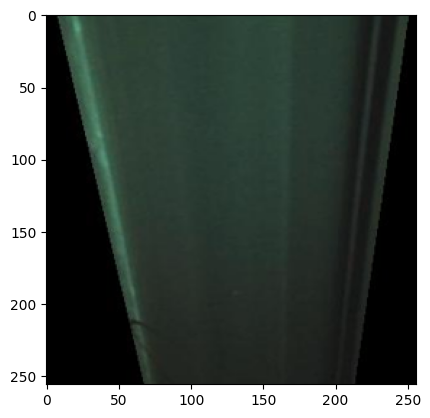

In [212]:
plt.imshow(bad_dataset[1])

In [17]:
X_test_recon = autoencoder.predict(bad_dataset)

3/3 [==============================] - 0s 6ms/step


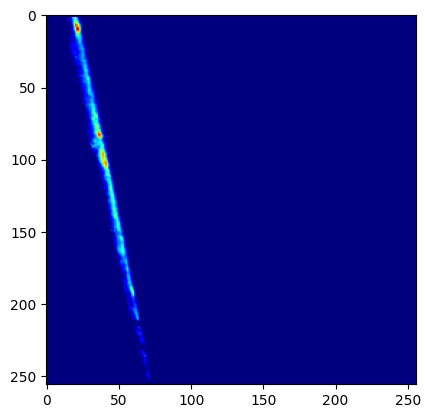

In [12]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm


heatmaps_array = np.zeros((result.shape[0], result.shape[1], result.shape[2], 3), dtype=np.uint8)

# Define your color thresholds
lower_threshold = 0
upper_threshold = 1 # Example value

for i in range(result.shape[0]):
    anomaly_map = result[i, :, :, 0]  # Assuming it's already normalized

    # Make a colormap that has your desired thresholds
    norm = colors.Normalize(vmin=lower_threshold, vmax=upper_threshold, clip=True)
    mapper = cm.ScalarMappable(norm=norm, cmap='jet')  # Replace 'jet' with any other colormap if you wish

    # Apply colormap to your data
    colored_map = mapper.to_rgba(anomaly_map)

    # Convert the colormap from RGBA to RGB, and scale to 8-bit
    colored_map = (colored_map[:, :, :3] * 255).astype(np.uint8)

    # Store the heatmap in the array
    heatmaps_array[i] = colored_map

plt.imshow(heatmaps_array[1])


In [15]:
import os
import cv2

output_dir = 'outauto'
o_2 = 'org'

for i in range (result.shape[0]):
    file_name = f"{i}.png"
    n_2 = f"{i}.png"

    file_path = os.path.join(output_dir, file_name)  # Combine directory path and file name
    file_path_2 = os.path.join(o_2, n_2)
    rgb_map = cv2.cvtColor(heatmaps_array[i], cv2.COLOR_BGR2RGB)

    cv2.imwrite(file_path, rgb_map)

In [14]:
import os
import cv2

output_dir = 'outauto'
o_2 = 'org'

for i in range (result.shape[0]):
    file_name = f"{i}.png"
    n_2 = f"{i}.png"

    file_path = os.path.join(output_dir, file_name)  # Combine directory path and file name
    file_path_2 = os.path.join(o_2, n_2)

    cv2.imwrite(file_path, result[i]*255)

In [16]:
import shutil

def zip_file(file_path, zip_path):
    shutil.make_archive(zip_path, 'zip', file_path)

# Specify the file path and the desired zip file path
file_path = 'outauto'
zip_path = 'auto'

# Call the function to create the zip file
zip_file(file_path, zip_path)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

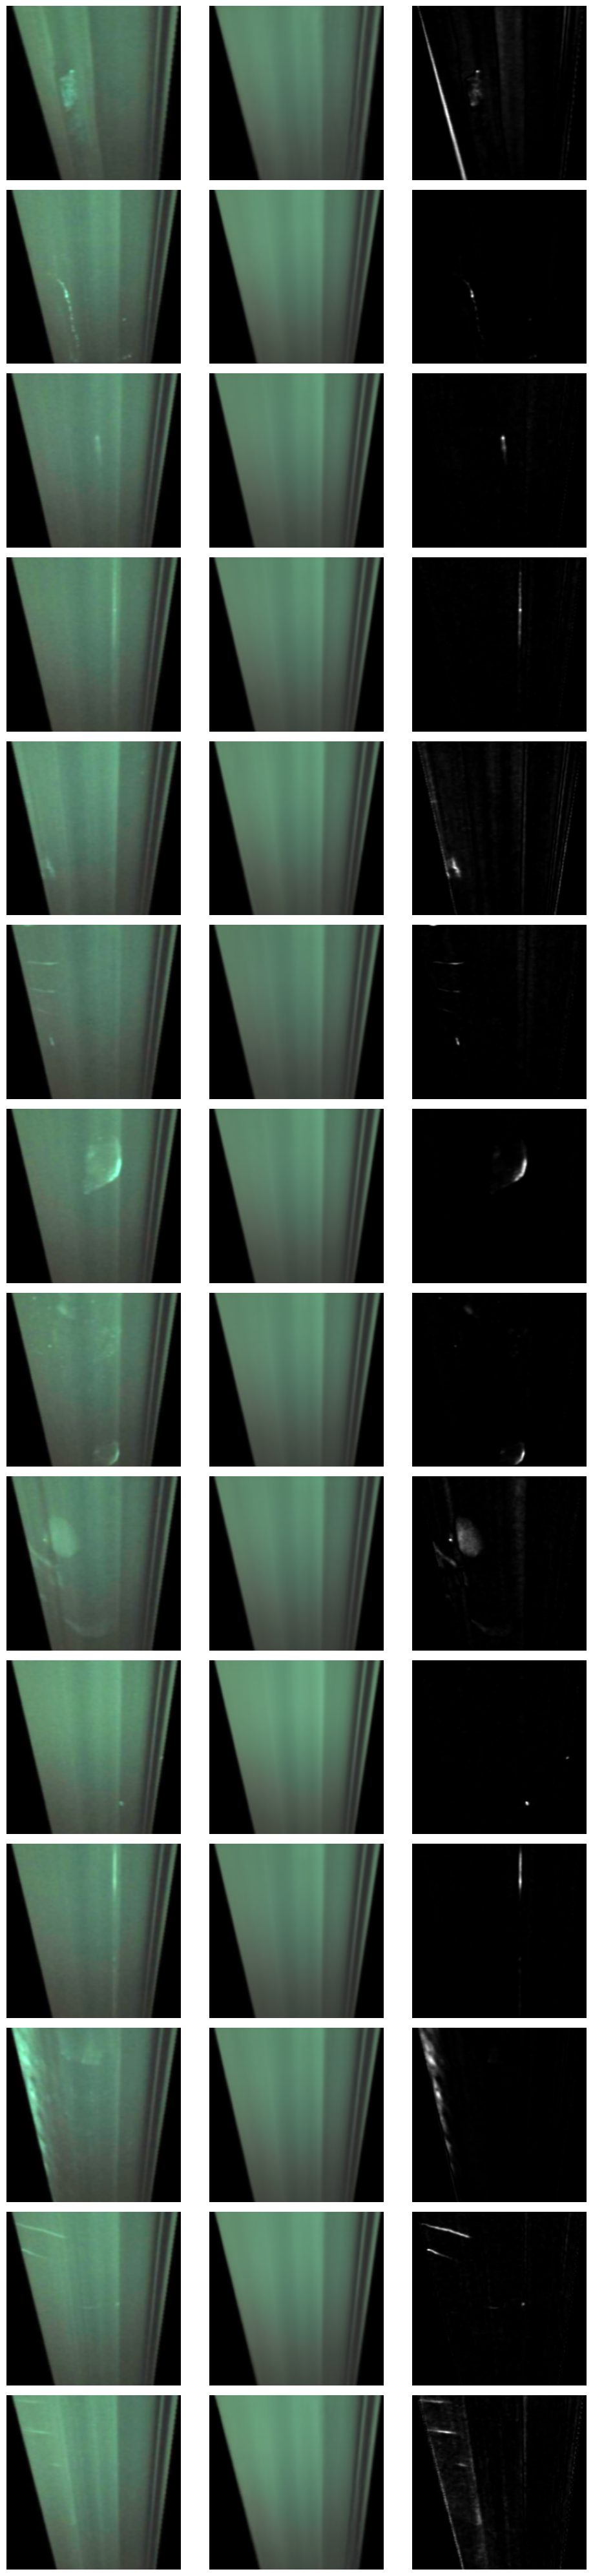

In [18]:
fig, axs = plt.subplots(14, 3 ,figsize=(10,40))
j = 0
for i in range(14):
        axs[i, j].imshow(bad_dataset[i+5])
        axs[i, j].axis('off')
        axs[i, j+1].imshow(X_test_recon[i+5])
        axs[i, j+1].axis('off')
        axs[i, j+2].imshow(anomaly_map[i+5], cmap='gray')
        axs[i, j+2].axis('off')
        j = 0

plt.tight_layout()
plt.show()